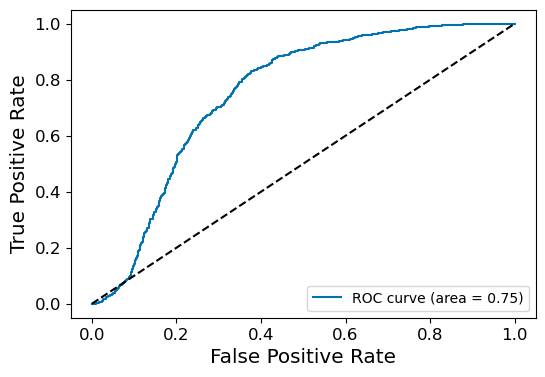

In [147]:
import os
import sys
import numpy as np
import torch



project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)
from experiments.MNIST import ExperimentMNIST



from experiments.MNIST import ExperimentMNIST
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM


import random
# seed = random.randint(0, 1000)
seed = 10
exp = ExperimentMNIST(0.1, 0.1, seed=seed)

# Create a model
model = OneClassSVM(kernel='rbf', nu=.1, gamma=0.001)
x_train, y_train = zip(*[(_x, _y) for _x, _y in exp.train_dataset])
x_train, y_train = torch.stack(x_train), torch.tensor(y_train)

x_train = x_train.reshape(-1, 28*28)
_x_train = x_train.numpy()

_x_train = _x_train[y_train == 0]
# randperm 1000 samples
_x_train = _x_train[np.random.permutation(_x_train.shape[0])[:2000]]
some_anomalies = x_train[y_train == 1].numpy()
anomalies = np.random.permutation(some_anomalies.shape[0])[:100]

_x_train = np.concatenate([_x_train, some_anomalies[anomalies]])


# Fit the model
model.fit(_x_train)

# Predict
x_test, y_test = zip(*[(_x, _y) for _x, _y in exp.test_dataset])
x_test, y_test = torch.stack(x_test), torch.tensor(y_test)

_y_test = y_test.numpy()
_y_test[_y_test == 1] = -1
_y_test[_y_test == 0] = 1

x_test = x_test.reshape(-1, 28*28)
y_pred = model.score_samples(x_test)

# Evaluate
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(_y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")

    plt.tick_params(axis='both', which='major', labelsize='large')

    plt.show()

In [148]:
y_pred = model.predict(x_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(_y_test, y_pred)
print(cm)


[[ 426  602]
 [  71 1064]]


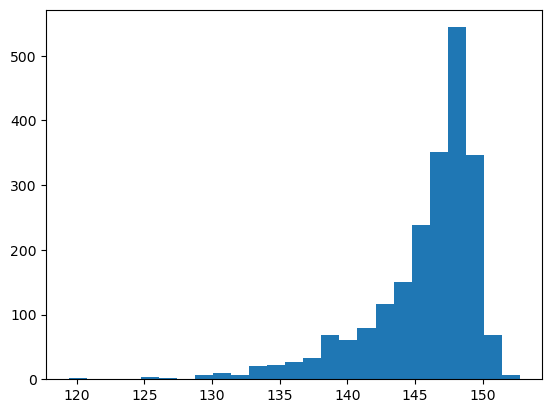

In [150]:
score = model.score_samples(x_test)
plt.hist(score, 25)
plt.show()

In [151]:
from sklearn.metrics import roc_curve

# Asumiendo que tienes las puntuaciones de predicción de tu modelo en y_scores
fpr, tpr, thresholds = roc_curve(y_test, score)

# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 146.04877573583627


In [152]:
from sklearn.metrics import roc_curve

# Asumiendo que tienes las puntuaciones de predicción de tu modelo en y_scores
fpr, tpr, thresholds = roc_curve(y_test, score)

# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 146.04877573583627


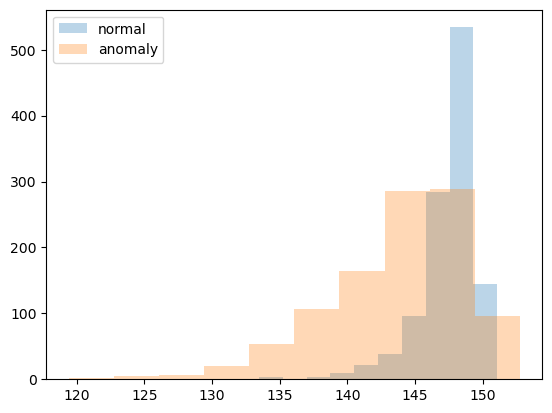

In [153]:
plt.hist(score[np.argwhere(_y_test==1).squeeze()], bins=10, alpha=.3, label='normal')
plt.hist(score[np.argwhere(_y_test==-1).squeeze()], bins=10, alpha=.3, label='anomaly')
plt.legend()
plt.show()

# Different number

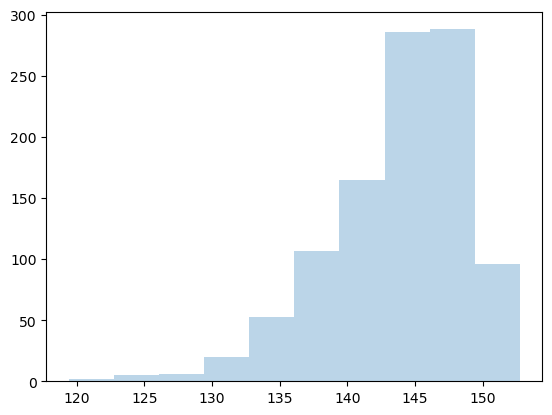

In [159]:
from torchvision.transforms import Normalize,ToTensor, Compose
from torchvision.datasets import MNIST
from torch.utils.data import Subset

## Extract a 2 from the test dataset
number = 7
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
test2_dataset = MNIST('data/', train = False, download = True, transform=transform)
test2_idx = torch.where((test2_dataset.targets == number))[0]
test2_dataset = Subset(test2_dataset, test2_idx)

X, y = zip(*test2_dataset)
X = torch.stack(X).reshape(-1, 28*28)
y = torch.tensor(y).flatten()
y_score = model.score_samples(X)
# y_pred = np.zeros_like(y_score, dtype=np.int)
# y_pred[y_score > 3] = 1
# y_score = model(X).detach()[:,1]

plt.hist(y_score, bins=10, alpha=.3, label='normal')
plt.show()

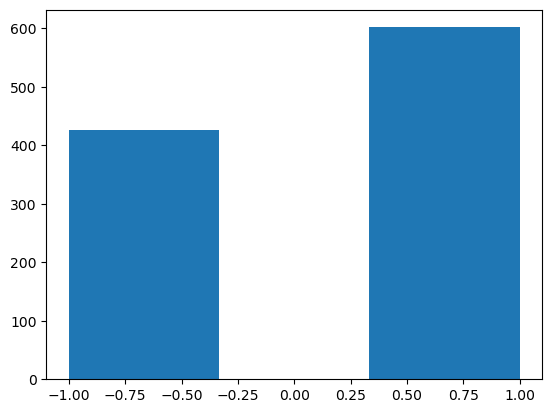

In [160]:
x_hat = model.predict(X)
plt.hist(x_hat, bins=3)
plt.show()

In [9]:
y_pred = y_score > 1e-2
np.unique(y_pred), np.bincount(y_pred)

(array([ True]), array([  0, 980]))

In [10]:
import numpy as np
from scipy import stats

# Tus datos
data1 = score[_y_test==1]
data2 = score[_y_test==-1]

# Realizar la prueba t
t_stat, p_value = stats.ttest_ind(data1, data2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 51.05046712924969
p-value: 0.0


In [11]:
score[np.argwhere(_y_test==-1).squeeze()].mean()

894.3045077121745

In [13]:
x,y = zip(*[(x,y)for x, y in exp.test_dataset])
x = torch.stack(x)
y = torch.tensor(y)

percent = .1

normal_idx = torch.argwhere(y == 0).flatten()
n = int(len(normal_idx) * percent)
idx = torch.randperm(len(normal_idx))
normal_idx = normal_idx[idx[:n]]

anomaly_idx = torch.argwhere(y == 1).flatten()
n = int(len(anomaly_idx) * percent)
idx = torch.randperm(len(anomaly_idx))
anomaly_idx = anomaly_idx[idx[:n]]

idx = torch.cat([normal_idx, anomaly_idx])
x_test, y_test = x[idx], y[idx]
x_test = x_test.reshape(len(y_test), -1)

In [15]:
print(x.shape, y.shape)
y[normal_idx].shape, y[anomaly_idx].shape

torch.Size([2163, 1, 28, 28]) torch.Size([2163])


(torch.Size([113]), torch.Size([102]))

In [16]:
x_test.shape, y_test.shape

(torch.Size([215, 784]), torch.Size([215]))

In [ ]:
# idx = torch.cat([normal_idx, anomaly_idx])
# x_train = x[idx]
# y_train = y[idx]

# model = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto')
# x_train = x_train.reshape(-1, 28*28)
# _x_train = x_train.numpy()

# scaler = StandardScaler()
# _x_train = scaler.fit_transform(_x_train)

# model.fit(_x_train)
# x_test = x.reshape(-1, 28*28)
# _x_test = scaler.transform(x_test)

# y_pred = model.predict(_x_test)
# fpr, tpr, _ = roc_curve(y, y_pred)
# roc_auc = auc(fpr, tpr)

# Optimizing OC-SVM

In [144]:
from sklearn.model_selection import PredefinedSplit

seed = 100
exp = ExperimentMNIST(0.0, 0.1, seed=seed)

x_train, y_train = zip(*[(_x, _y) for _x, _y in exp.train_dataset])
x_train, y_train = torch.stack(x_train), torch.tensor(y_train)

x_test, y_test = zip(*[(_x, _y) for _x, _y in exp.test_dataset])
x_test, y_test = torch.stack(x_test), torch.tensor(y_test)
# pick the 10% of the x_test, 5% of the anomalies and 5% of the normal samples
percent = .05
normal_idx = torch.argwhere(y_test == 0).flatten()
n = int(len(normal_idx) * percent)
idx = torch.randperm(len(normal_idx))
normal_idx = normal_idx[idx[:n]]

anomaly_idx = torch.argwhere(y_test == 1).flatten()
n = int(len(anomaly_idx) * percent)
idx = torch.randperm(len(anomaly_idx))
anomaly_idx = anomaly_idx[idx[:n]]

idx = torch.cat([normal_idx, anomaly_idx])
x_test, y_test = x_test[idx], y_test[idx]


# concatenate x_train and x_test
X = torch.concat([x_train, x_test], dim=0).reshape(-1, 28*28)
y = torch.concat([y_train, y_test], dim=0)
y[y == 1] = -1
y[y == 0] = 1


test_fold = [-1]*len(x_train) + [0]*len(x_test)
ps = PredefinedSplit(test_fold)

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM

param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 8),
                     'nu': [0.1, 0.3, 0.5, 0.9]}

grid = GridSearchCV(OneClassSVM(), param_grid, scoring='f1', verbose=3, cv=ps, n_jobs=-1)
grid.fit(X, y)
best_params = grid.best_params_

Fitting 1 folds for each of 32 candidates, totalling 32 fits
[CV 1/1] END ...gamma=0.001, kernel=rbf, nu=0.1;, score=0.800 total time=   2.1s
[CV 1/1] END gamma=0.003727593720314938, kernel=rbf, nu=0.1;, score=0.800 total time=   2.3s
[CV 1/1] END gamma=0.013894954943731374, kernel=rbf, nu=0.1;, score=0.836 total time=   2.4s
[CV 1/1] END ...gamma=0.001, kernel=rbf, nu=0.3;, score=0.871 total time=   6.0s
[CV 1/1] END gamma=0.003727593720314938, kernel=rbf, nu=0.3;, score=0.857 total time=   6.1s
[CV 1/1] END gamma=0.013894954943731374, kernel=rbf, nu=0.3;, score=0.857 total time=   6.5s
[CV 1/1] END gamma=0.0517947467923121, kernel=rbf, nu=0.1;, score=0.783 total time=   6.5s
[CV 1/1] END gamma=0.0517947467923121, kernel=rbf, nu=0.3;, score=0.783 total time=   8.4s
[CV 1/1] END ...gamma=0.001, kernel=rbf, nu=0.5;, score=0.756 total time=   8.4s
[CV 1/1] END gamma=0.003727593720314938, kernel=rbf, nu=0.5;, score=0.742 total time=   9.0s
[CV 1/1] END gamma=0.013894954943731374, kernel=r

In [146]:
best_params

{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.3}

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

def make_custom_scorer(X):
    def score_oc_svm(estimator, X_test):
        score = model.score_samples(X)
        fpr, tpr, _ = roc_curve(y, score)
        return auc(fpr, tpr)
    return score_oc_svm

custom_scorer = make_scorer(make_custom_scorer(x_test, y_test), greater_is_better=True)

param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 8),
                     'nu': [0.01, 0.05, 0.1, 0.5]}

grid = GridSearchCV(OneClassSVM(), param_grid, refit=True, verbose=1, scoring=custom_scorer)
grid.fit(_x_train)

best_params = grid.best_params_

In [ ]:
from hypopt import GridSearch

param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 8),
                     'nu': [0.01, 0.05, 0.1, 0.5]}

opt = GridSearch(model = OneClassSVM(), param_grid=param_grid, num_threads=2, parallelize=True)
opt.fit(_x_train, y_train, x_test, y_test)


In [ ]:
x = np.random.randn(100, 2)
y = np.random.randn(100, 2)
model.fit(x, y)

In [ ]:
def make_custom_scorer(model, X, **kwargs):
    def score_oc_svm(y_pred):
        # Ignorar y_true y y_pred
        # Usar model, X y y para calcular la puntuación
        y_pred = model.predict(X)
        score = 1
        return score
    return score_oc_svm

custom_scorer = make_scorer(make_custom_scorer(model, x_test, y=y_test), greater_is_better=True)

param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 8),
                     'nu': [0.01, 0.05, 0.1, 0.5]}

grid = GridSearchCV(OneClassSVM(), param_grid, refit=True, verbose=0, scoring='accuracy', n_jobs=1)
grid.fit(_x_train)

best_params = grid.best_params_

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import OneClassSVM
import numpy as np

def custom_cross_val(X, y, model, param_grid, cv=5):
    kf = KFold(n_splits=cv)
    best_score = -1
    best_params = None

    for params in param_grid:
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.set_params(**params)
            model.fit(X_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            scores.append(score)
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
    return best_params, best_score

model = OneClassSVM()
param_grid = [{'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 8), 'nu': [0.01, 0.05, 0.1, 0.5]}]
best_params, best_score = custom_cross_val(_x_train, y_train, model, param_grid, cv=5)

print("Best parameters:", best_params)
print("Best score:", best_score)

In [ ]:
from matplotlib import pyplot as plt
plt.hist(score, bins=25)
plt.show()

In [ ]:
# Cross validation using training set for obtaining the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 10),
                     'nu': [0.1, 0.2, 0.3, 0.4, 0.5]}]

scores = ['roc_auc_ovr']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        OneClassSVM(), tuned_parameters, scoring=score
    )
    clf.fit(x_train.numpy())

    # print("Best parameters set found on development set:")
    # print()
    # print(clf.best_params_)
    # print()
    # print("Grid scores on development set:")
    # print()
    # means = clf.cv_results_['mean_test_score']
    # stds = clf.cv_results_['std_test_score']
    # for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #     print("%0.3f (+/-%0.03f) for %r"
    #           % (mean, std * 2, params))
    # print()

    # print("Detailed classification report:")
    # print()
    # print("The model is trained on the full development set.")
    # print("The scores are computed on the full evaluation set.")
    # print()
    # y_true, y_pred = y_test, clf.predict(x_test.numpy())
    # # print(classification_report(y_true, y_pred))
    # # print()

# Pruebas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(
            real_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(
            new_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)

ax[0, 5].set_title("Selection from the input data")
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

In [ ]:
x_train, y_train = zip(*[(_x, _y) for _x, _y in exp.train_dataset])
x_train, y_train = torch.stack(x_train), torch.tensor(y_train)

x_train = x_train[y_train==0].view(-1, 28*28).numpy()
y_train = y_train[y_train==0].numpy()


In [ ]:
class CustomOneCLassSVM(OneClassSVM):
    def __init__(self, X_test, y_test, kernel='rbf', gamma='scale',
                 nu=0.5, **kwargs):
        super().__init__(kernel=kernel, gamma=gamma, nu=nu, **kwargs)
        self.X_test = X_test
        self.y_test = y_test
    
    def score(self, X, y=None):
        from sklearn.metrics import roc_curve, auc
        score = super().score_samples(self.X_test)
        fpr, tpr, _ = roc_curve(self.y_test, score)
        return auc(fpr, tpr)
    

param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 1, 1),
                     'nu': [0.01, 0.05, 0.1, 0.5]}

_y_test = y_test.numpy()
_y_test[_y_test == 1] = -1
_y_test[_y_test == 0] = 1

my_scorer = make_scorer(CustomOneCLassSVM.score)
grid = GridSearchCV(CustomOneCLassSVM(x_test, y_test), param_grid, refit=True, verbose=2, n_jobs=1)
grid.fit(x_train, y_train)

best_params = grid.best_params_

In [ ]:
# model = CustomOneCLassSVM(x_test, y_test, **best_params)
model = CustomOneCLassSVM(x_test, y_test, kernel='rbf', gamma=.1, nu=1e-3)
model.fit(x_train, y_train)
model.score(None, None)

In [ ]:
best_params

# MedMNIST Test

In [ ]:
import os, sys
from torchvision import transforms
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from dataset.medmnist import AnomalyPneumoniaMNIST

In [ ]:
from dataset import AnomalyPneumoniaMNIST
from matplotlib import pyplot as plt
from torchvision import transforms
import random
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# Load the dataset
# create a random seed
seed = 128
train_dataset = AnomalyPneumoniaMNIST('data/', download=True, transform=data_transform, n_normal_samples=-1, known_anomalies=0.2, pollution=0.0, seed=seed)
print(train_dataset)

train_dataset.montage(5, 5, seed)
plt.show()

In [ ]:
x_train, y_train = zip(*[(_x, _y) for _x, _y in train_dataset])
x_train, y_train = torch.stack(x_train), torch.tensor(y_train)

_x_train = x_train[y_train==0].view(-1, 28*28).numpy()
_y_train = y_train[y_train==0].numpy()

model = OneClassSVM(kernel='rbf', gamma=1e-2, nu=1e-3)
model.fit(_x_train)

# Predict
x_test, y_test = zip(*[(_x, _y) for _x, _y in train_dataset])
x_test, y_test = torch.stack(x_test), torch.tensor(y_test)

_y_test = y_test.numpy()
_y_test[_y_test == 1] = -1
_y_test[_y_test == 0] = 1

x_test = x_test.reshape(-1, 28*28)
_y_pred = model.score_samples(x_test)

# Evaluate
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(_y_test, _y_pred)
roc_auc = auc(fpr, tpr)

# Plot
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")

    plt.tick_params(axis='both', which='major', labelsize='large')

    plt.show()

In [ ]:
score = model.score_samples(x_test)
plt.hist(score, 25)
plt.show()

from sklearn.metrics import roc_curve

# Asumiendo que tienes las puntuaciones de predicción de tu modelo en y_scores
fpr, tpr, thresholds = roc_curve(y_test, score)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.show()

In [ ]:
plt.hist(score[torch.argwhere(y_test==1).squeeze()], bins=25, alpha=.5, label='normal')
plt.hist(score[torch.argwhere(y_test==-1).squeeze()], bins=25, alpha=.5, label='anomaly')
plt.legend()
plt.show()

In [ ]:
# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

In [ ]:
import numpy as np
from scipy import stats

# Tus datos
data1 = score[_y_test==1]
data2 = score[_y_test==-1]

# Realizar la prueba t
t_stat, p_value = stats.ttest_ind(data1, data2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")